In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import os
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# ---------------------------------------------------------
# 1. 환경변수 로드 (notebooks 폴더의 상위 폴더에 있는 .env 로드)
# ---------------------------------------------------------
load_dotenv(dotenv_path="../.env")

# 2. DB 연결
DB_CONFIG = {
    "host": os.getenv("DB_HOST"),
    "port": int(os.getenv("DB_PORT", 3306)),
    "user": os.getenv("DB_USER", "admin"),
    "password": os.getenv("DB_PASSWORD"),
    "db": os.getenv("DB_NAME", "projectl")
}

db_url = f"mysql+pymysql://{DB_CONFIG['user']}:{DB_CONFIG['password']}@{DB_CONFIG['host']}:{DB_CONFIG['port']}/{DB_CONFIG['db']}"
engine = create_engine(db_url)
print("✅ DB 연결 성공!")

# ---------------------------------------------------------
# 3. 데이터 수집 함수 (스키마 컬럼명 수정 완료)
# ---------------------------------------------------------
def get_item_data(item_name):
    conn = engine.connect()
    try:
        # (1) 아이템 ID 찾기
        item_sql = text("SELECT id FROM market_items WHERE name = :name")
        item_id = conn.execute(item_sql, {"name": item_name}).scalar()
        
        if not item_id:
            print(f"❌ '{item_name}' 아이템을 찾을 수 없습니다.")
            return None, None

        print(f"🔍 '{item_name}' (ID: {item_id}) 데이터 수집 중...")

        # (2) 가격 로그 가져오기 (컬럼명: current_min_price, logged_at)
        price_sql = text("""
            SELECT logged_at, current_min_price
            FROM market_price_logs
            WHERE item_id = :item_id
            ORDER BY logged_at ASC
        """)
        df_prices = pd.read_sql(price_sql, conn, params={"item_id": item_id})
        
        # (3) GPT Score 가져오기 (컬럼명: notice_date, gpt_score)
        notice_sql = text("""
            SELECT r.notice_date, i.gpt_score
            FROM item_notice_impacts i
            JOIN raw_notices r ON i.notice_id = r.id
            WHERE i.item_id = :item_id
            ORDER BY r.notice_date ASC
        """)
        df_notices = pd.read_sql(notice_sql, conn, params={"item_id": item_id})
        
        print(f"   - 가격 로그: {len(df_prices)}개")
        print(f"   - 관련 공지: {len(df_notices)}개")
        
        return df_prices, df_notices

    finally:
        conn.close()

# ---------------------------------------------------------
# [테스트] 아이템 이름 입력
# ---------------------------------------------------------
TARGET_ITEM = "운명의 파괴석"  # 👈 분석하고 싶은 아이템 이름
df_raw, df_gpt = get_item_data(TARGET_ITEM)

display(df_raw.head())
display(df_gpt.head())

✅ DB 연결 성공!
🔍 '운명의 파괴석' (ID: 66102006) 데이터 수집 중...
   - 가격 로그: 7464개
   - 관련 공지: 8개


,logged_at,current_min_price
0,2025-12-18 11:00:10.958607,99
1,2025-12-18 11:10:47.801668,100
2,2025-12-18 11:21:26.091468,98
3,2025-12-18 11:32:02.106706,100
4,2025-12-18 11:42:37.977318,98


,notice_date,gpt_score
0,2025-12-17,0.0
1,2025-12-24,0.0
2,2025-12-31,0.0
3,2026-01-07,0.5
4,2026-01-14,0.0


In [3]:
from datetime import timedelta

# =========================================================
# 함수 1: 가격 데이터 정제 (구멍 메우기 + OHLC)
# =========================================================
def preprocess_ohlc_and_fill(df_raw):
    print("🧹 [1단계] 가격 데이터 정제 및 시간 구멍 메우기...")
    
    df = df_raw.copy()
    
    # 1. 인덱스 설정
    if 'logged_at' in df.columns:
        df['logged_at'] = pd.to_datetime(df['logged_at'])
        df.set_index('logged_at', inplace=True)
    
    # 2. 30분 단위 Resampling
    df_resampled = df['current_min_price'].resample('30min').agg(['first', 'max', 'min', 'last', 'mean'])
    df_resampled.columns = ['Open', 'High', 'Low', 'Close', 'Price_Mean']
    
    # 3. 빈칸 채우기 (Forward Fill -> Backward Fill)
    df_filled = df_resampled.ffill().bfill()
    
    print(f"   - 정제 완료: {len(df_filled)}개 구간")
    return df_filled

# =========================================================
# 함수 2: GPT 스코어 매핑 (날짜 계산 로직)
# =========================================================
def apply_gpt_scores(df_price, df_gpt):
    print("🤖 [2단계] GPT 공지사항 점수 매핑 중...")
    
    df = df_price.copy()
    df['GPT_Score'] = 0.0 # 기본값 0
    
    if df_gpt is None or df_gpt.empty:
        print("   - 공지사항 데이터가 없습니다. (점수 0으로 진행)")
        return df

    count = 0
    for idx, row in df_gpt.iterrows():
        notice_date = pd.to_datetime(row['notice_date'])
        score = row['gpt_score']
        
        # [규칙 적용] 공지일 10:00 ~ 7일 뒤 06:00
        start_time = notice_date.replace(hour=10, minute=0, second=0)
        end_time = (notice_date + timedelta(days=7)).replace(hour=6, minute=0, second=0)
        
        # 해당 기간 마스킹
        mask = (df.index >= start_time) & (df.index < end_time)
        
        if mask.any():
            df.loc[mask, 'GPT_Score'] = score
            count += 1
            
    print(f"   - 총 {count}건의 공지사항 점수 반영 완료")
    return df

# =========================================================
# [실행] 두 함수 연결해서 최종 데이터 만들기
# =========================================================

# 1. 가격 데이터 정제
df_clean_price = preprocess_ohlc_and_fill(df_raw)

# 2. GPT 점수 결합
df_final = apply_gpt_scores(df_clean_price, df_gpt)

# 3. 결과 확인
print("-" * 30)
print(f"🗓️ 데이터 기간: {df_final.index.min()} ~ {df_final.index.max()}")
print("-" * 30)
display(df_final.tail()) # 최근 데이터 확인

🧹 [1단계] 가격 데이터 정제 및 시간 구멍 메우기...
   - 정제 완료: 2587개 구간
🤖 [2단계] GPT 공지사항 점수 매핑 중...
   - 총 8건의 공지사항 점수 반영 완료
------------------------------
🗓️ 데이터 기간: 2025-12-18 11:00:00 ~ 2026-02-10 08:00:00
------------------------------


,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-10 06:00:00,322.0,322.0,321.0,322.0,321.666667,0.0
2026-02-10 06:30:00,324.0,327.0,324.0,327.0,325.333333,0.0
2026-02-10 07:00:00,322.0,324.0,313.0,313.0,319.666667,0.0
2026-02-10 07:30:00,319.0,320.0,312.0,312.0,317.000000,0.0
2026-02-10 08:00:00,312.0,312.0,312.0,312.0,312.000000,0.0


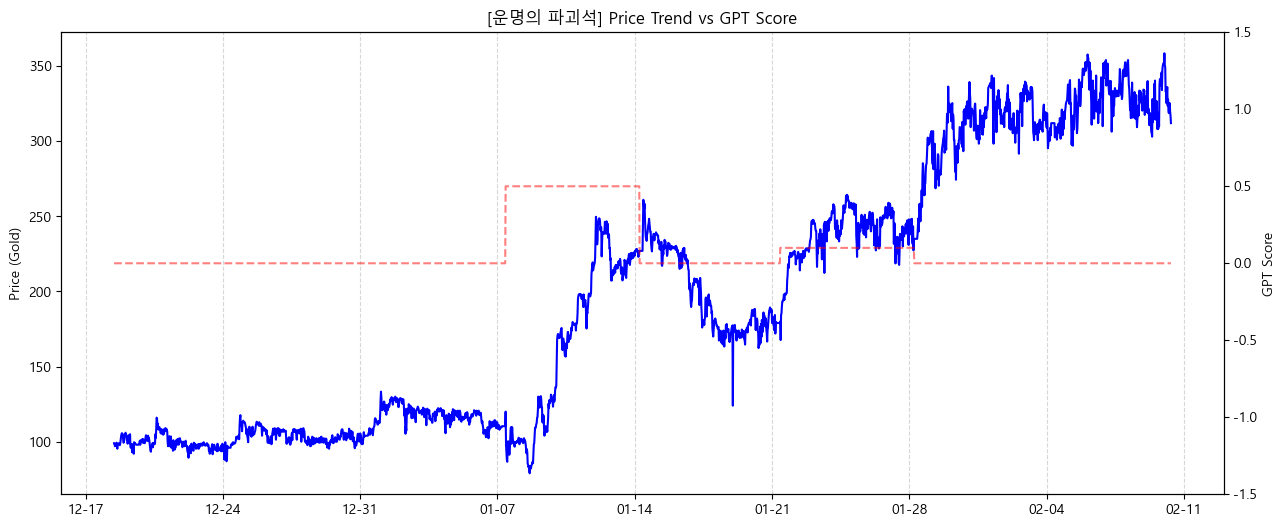

,Open,High,Low,Close,Price_Mean,GPT_Score
logged_at,,,,,,
2026-02-10 06:00:00,322.0,322.0,321.0,322.0,321.666667,0.0
2026-02-10 06:30:00,324.0,327.0,324.0,327.0,325.333333,0.0
2026-02-10 07:00:00,322.0,324.0,313.0,313.0,319.666667,0.0
2026-02-10 07:30:00,319.0,320.0,312.0,312.0,317.000000,0.0
2026-02-10 08:00:00,312.0,312.0,312.0,312.0,312.000000,0.0


In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ---------------------------------------------------------
# 3. 시각화 (확인용)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# 가격 그래프 (파란색)
ax1 = plt.gca()
ax1.plot(df_final.index, df_final['Price_Mean'], color='blue', label='Avg Price')
ax1.set_ylabel('Price (Gold)')

# GPT 점수 그래프 (빨간색, y축 공유)
ax2 = ax1.twinx()
ax2.plot(df_final.index, df_final['GPT_Score'], color='red', linestyle='--', alpha=0.5, label='GPT Score')
ax2.set_ylabel('GPT Score')
ax2.set_ylim(-1.5, 1.5)

# 2. 눈금 형식: '월-일' 형태로 보여줘라 (예: 01-29)
# 연도까지 보고 싶으면 '%Y-%m-%d'로 바꾸시면 됩니다.
ax1.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax1.grid(True, which='major', axis='x', linestyle='--', alpha=0.5) # 수요일마다 세로 점선 추가

plt.title(f"[{TARGET_ITEM}] Price Trend vs GPT Score")
plt.show()

# 데이터 확인
display(df_final.tail())

In [5]:
import pandas as pd
from neuralprophet import NeuralProphet, set_random_seed

# 랜덤 시드 고정 (재현성을 위해)
set_random_seed(42)

# 1. 데이터 포맷팅 (NeuralProphet 전용)
# df_final은 이미 구멍이 메워진 상태입니다.
df_np = df_final.reset_index()[['logged_at', 'Close', 'GPT_Score']].copy()

# 컬럼명 변경 (필수 규칙!)
df_np.columns = ['ds', 'y', 'GPT_Score']

print("✅ NeuralProphet용 데이터 준비 완료")
display(df_np.tail())

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


✅ NeuralProphet용 데이터 준비 완료


,ds,y,GPT_Score
2582,2026-02-10 06:00:00,322.0,0.0
2583,2026-02-10 06:30:00,327.0,0.0
2584,2026-02-10 07:00:00,313.0,0.0
2585,2026-02-10 07:30:00,312.0,0.0
2586,2026-02-10 08:00:00,312.0,0.0


In [6]:
# ---------------------------------------------------------
# 2. 모델 정의
# ---------------------------------------------------------
m = NeuralProphet(
    n_forecasts=336,        # 미래 7일(336개 30분봉)을 한 번에 예측
    n_lags=672,              # 과거 2주(672개) 데이터를 보고 예측
    
    # 로스트아크 특화 설정
    weekly_seasonality=True, # 수요일 점검 등의 주간 패턴 학습
    daily_seasonality=True,  # 새벽/저녁 패턴 학습
    yearly_seasonality=False,# 1년치 데이터는 아니므로 끔
    
    # 학습률 등 (자동으로 잡지만, 불안정하면 조절 가능)
    learning_rate=0.01,
)

# 3. GPT 점수(공지사항)를 '미래를 아는 변수'로 추가
# (우리가 미래 공지사항은 없다고(0) 가정하고 입력할 것이기 때문)
m.add_future_regressor("GPT_Score")

# ---------------------------------------------------------
# 3. 학습 (Train)
# ---------------------------------------------------------
print("🧠 NeuralProphet 학습 시작... (GPU/CPU에 따라 시간 소요)")

# 학습 데이터와 검증 데이터 나누기 (2월 4일 기준)
cutoff_date = pd.to_datetime("2026-02-04 06:00:00")
df_train = df_np[df_np['ds'] < cutoff_date]
df_test = df_np[df_np['ds'] >= cutoff_date]

# 학습 실행
metrics = m.fit(df_train, freq="30min")

print("✅ 학습 완료!")

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency 30min corresponds to 99.956% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - 30min
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 32
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 100


🧠 NeuralProphet 학습 시작... (GPU/CPU에 따라 시간 소요)
Training: |          | 0/? [00:40<?, ?it/s, v_num=0, train_loss=0.0024, reg_loss=0.000, MAE=7.860, RMSE=10.30, Loss=0.00239, RegLoss=0.000] 
✅ 학습 완료!


In [7]:
from neuralprophet import save

# 1. 모델 저장하기
# 확장자는 보통 .np (NeuralProphet) 또는 .pkl (Pickle)을 씁니다.
model_filename = "lostark_price_model.np"
save(m, model_filename)

print(f"✅ 모델 저장 완료! 파일명: {model_filename}")
print("   (이 파일을 서버로 복사해서 쓰시면 됩니다)")

✅ 모델 저장 완료! 파일명: lostark_price_model.np
   (이 파일을 서버로 복사해서 쓰시면 됩니다)


In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

import warnings
import logging
# 1. 빨간 경고 메시지 무시
warnings.filterwarnings("ignore")

# 2. NeuralProphet 로그 레벨 조정 (INFO 메시지 숨기기)
logging.getLogger("NP.df_utils").setLevel(logging.ERROR)

INFO - (NP.data.processing._handle_missing_data) - Dropped 336 rows at the end with NaNs in 'y' column.


🔮 전체 기간 예측 중... (잠시만 기다려주세요)
Predicting DataLoader 0: 100%|██████████| 2/2 [00:00<00:00, 17.34it/s]
✅ 7일치 예측값 추출 완료! (336개)


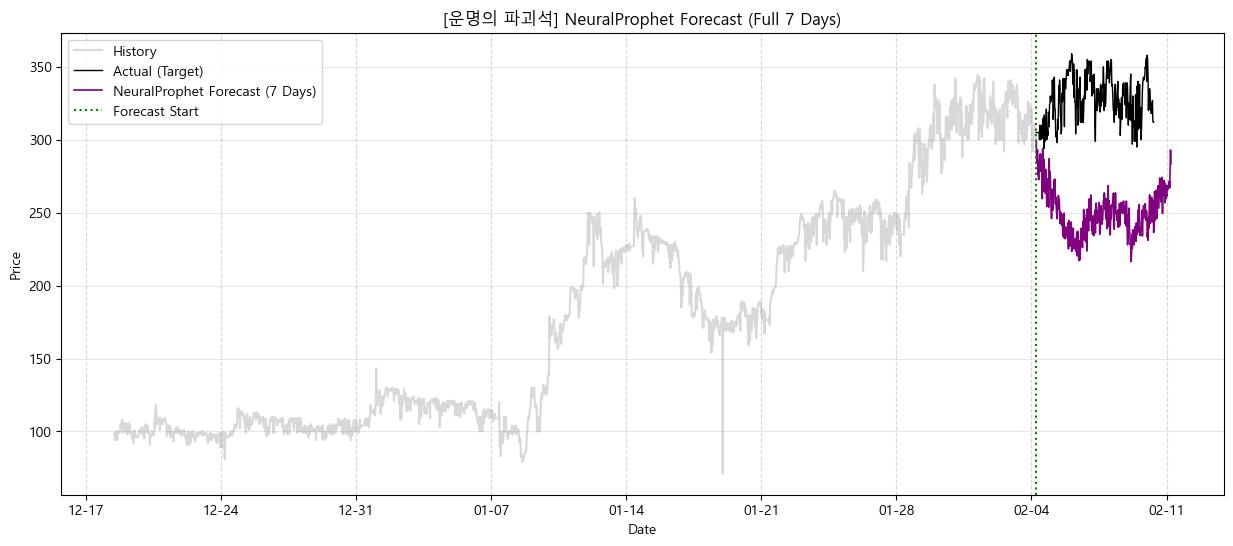

In [9]:
from datetime import timedelta
import numpy as np

# ---------------------------------------------------------
# 1. 데이터프레임 다시 만들기 (과거 포함 필수!)
# ---------------------------------------------------------
# 중요: n_historic_predictions=True로 해야 '마지막 학습 시점'의 행이 포함됩니다.
future_regressors = pd.DataFrame(data={'GPT_Score': [0.0] * 336})

future = m.make_future_dataframe(
    df_train,
    periods=336,
    n_historic_predictions=True, # 👈 여기가 핵심 변경 (True)
    regressors_df=future_regressors
)

print("🔮 전체 기간 예측 중... (잠시만 기다려주세요)")
forecast = m.predict(future)

# ---------------------------------------------------------
# 2. [핵심] '마지막 학습 날짜'에 쏜 336개 예측값만 추출
# ---------------------------------------------------------
# 우리가 학습시킨 마지막 날짜 (기준점)
last_train_date = df_train['ds'].max()

# 그 날짜의 행(Row)을 찾습니다.
target_row = forecast[forecast['ds'] == last_train_date].iloc[0]

# yhat1 ~ yhat336 값을 순서대로 뽑아서 리스트로 만듭니다.
pred_values = []
for i in range(1, 337):
    pred_values.append(target_row[f"yhat{i}"])

# 예측값에 대응하는 미래 날짜 만들기
future_dates = pd.date_range(start=last_train_date + timedelta(minutes=30), periods=336, freq='30min')

print(f"✅ 7일치 예측값 추출 완료! ({len(pred_values)}개)")

# ---------------------------------------------------------
# 3. 그래프 그리기 (끊김 없음)
# ---------------------------------------------------------
plt.figure(figsize=(15, 6))

# (1) 과거 데이터
plt.plot(df_train['ds'], df_train['y'], label='History', color='gray', alpha=0.3)

# (2) 실제 정답 (있다면)
if not df_test.empty:
    plt.plot(df_test['ds'], df_test['y'], label='Actual (Target)', color='black', linewidth=1)

# (3) NeuralProphet 7일 예측 (추출한 값 사용)
plt.plot(future_dates, pred_values, label='NeuralProphet Forecast (7 Days)', color='purple', linewidth=1.2)

# 스타일
plt.axvline(last_train_date, color='green', linestyle=':', label='Forecast Start')
plt.title(f"[{TARGET_ITEM}] NeuralProphet Forecast (Full 7 Days)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True, alpha=0.3)

# X축 날짜 포맷
ax = plt.gca()
ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=mdates.WEDNESDAY, interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.grid(True, which='major', axis='x', linestyle='--', alpha=0.5)
plt.show()

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---------------------------------------------------------
# 4. 채점하기 (성능 평가)
# ---------------------------------------------------------

# (1) 정답지 준비: 실제 데이터(Test)에서 예측한 기간(336개)만큼만 가져오기
# 예측은 '2026-02-04 06:30' 부터 시작되므로, df_test도 그 시점부터 336개를 잘라야 합니다.
actual_values = df_test['y'].iloc[:336].values

# (2) 답안지 준비: 아까 추출한 예측값 (pred_values)
predicted_values = np.array(pred_values)

# (3) 에러 계산
# RMSE: 오차의 제곱 평균 (큰 오차에 페널티를 더 줌)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))

# MAE: 오차의 절대값 평균 (직관적으로 '몇 골드 틀렸나' 알기 좋음)
mae = mean_absolute_error(actual_values, predicted_values)

# (4) 결과 출력
print(f"📊 [성적표] 향후 7일간 예측 성능")
print(f"---------------------------------------")
print(f"1. RMSE (평균 제곱근 오차): {rmse:.2f} Gold")
print(f"2. MAE  (평균 절대 오차)  : {mae:.2f} Gold")
print(f"---------------------------------------")

if mae < 50:
    print("🌟 오! 상당히 정확한 편입니다. (오차 50골드 미만)")
elif mae < 100:
    print("🙂 준수한 성능입니다. (오차 100골드 미만)")
else:
    print("🤔 개선이 필요해 보입니다. (오차가 큼)")

ValueError: Found input variables with inconsistent numbers of samples: [293, 336]